# Modified toy model for UHECR track generation

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
from generate_sample_frames_modified import *
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from matplotlib import pyplot as plt
import pickle

C:\Users\Figge\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


genarated 360 frames of background
genarated 360 background labels
displaying a random sample of 36 frames: 


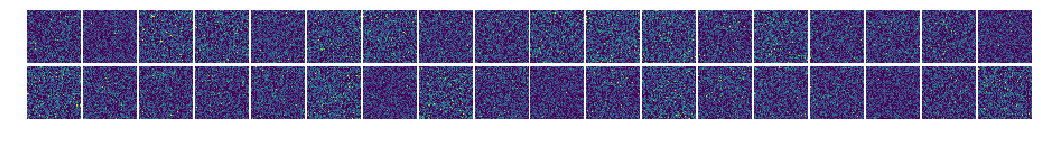

generated 360 frames of tracks
genarated 360 track labels
displaying a random sample of 36 frames: 


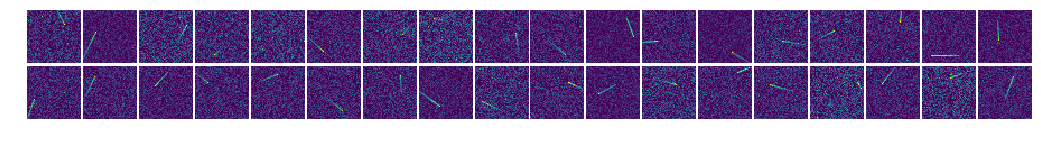

saved generated frames to file in samples/


In [2]:
# set up the TrackModel
track_model = TrackModel()
track_model.mu_c = 10
n_frame = 360

# generate sample background and tracks
with SampleGenerator(track_model) as generator:
    generator.background(n_frame)
    generator.tracks(n_frame)
    generator.save()

In [3]:
outfilename = 'samples/sample_generator_bg.dat'
with open(outfilename, 'rb') as f:
    data_bg = pickle.load(f)

outfilename = 'samples/sample_generator_track.dat'
with open(outfilename, 'rb') as f:
    data_track = pickle.load(f)

In [4]:
outfilename = 'samples/sample_generator_bg_labels.dat'
with open(outfilename, 'rb') as f:
    labels_bg = pickle.load(f)

outfilename = 'samples/sample_generator_track_labels.dat'
with open(outfilename, 'rb') as f:
    labels_track = pickle.load(f)

Look at the first background image
this image has label:  [0. 1.]


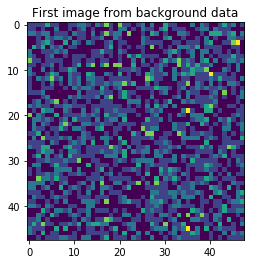

In [5]:
#Look at the first background image
print ("Look at the first background image")

plt.imshow(data_bg[0])
plt.title("First image from background data")

# and its corresponding label
print ("this image has label: ", labels_bg[0])

Look at the first track image
this image has label:  [1. 0.]


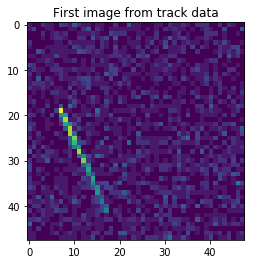

In [6]:
#Look at the first track image
print ("Look at the first track image")

plt.imshow(data_track[0])
plt.title("First image from track data")

# and its corresponding label
print ("this image has label: ", labels_track[0])

In [7]:
data = np.concatenate([data_bg, data_track])
data = np.reshape(data, (2*n_frame, 48, 48, 1))

labels = np.concatenate([labels_bg, labels_track])

data, labels = shuffle(data, labels)

validation_ratio = 1/5
index = int(1 - validation_ratio*np.shape(data)[0]/2)-1

data_test = data[index:]
labels_test = labels[index:]

data = data[0:index]
labels = labels[0:index]

In [8]:
# Shuffle the data
#data, labels = shuffle(data, labels)

# Make sure the data is normalized
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping, rotating and blurring the
# images on our data set.
#img_aug = ImageAugmentation()
#img_aug.add_random_flip_leftright()
#img_aug.add_random_rotation(max_angle=25.)
#img_aug.add_random_blur(sigma_max=3.)

# Define our network architecture:

# Input is a 48x48 image with 1 "color" channel
network = input_data(shape=[None, 48, 48, 1])#,
                     #data_preprocessing=img_prep,
                     #data_augmentation=img_aug)

# Step 1: Convolution
network = conv_2d(network, 48, 3, activation='relu')

# Step 2: Max pooling
network = max_pool_2d(network, 2)

# Step 3: Convolution again
network = conv_2d(network, 64, 3, activation='relu')

# Step 4: Convolution yet again
network = conv_2d(network, 64, 3, activation='relu')

# Step 5: Max pooling again
network = max_pool_2d(network, 2)

# Step 6: Fully-connected 512 node neural network
network = fully_connected(network, 512, activation='relu')

# Step 7: Dropout - throw away some data randomly during training to prevent over-fitting
network = dropout(network, 0.5)

# Step 8: Fully-connected neural network with two outputs
network = fully_connected(network, 2, activation='softmax')

# Tell tflearn how we want to train the network
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)

# Wrap the network in a model object
model = tflearn.DNN(network, tensorboard_verbose=3, checkpoint_path='track-classifier.tfl.ckpt')
#model = tflearn.DNN(network)

# Train it! We'll do 100 training passes and monitor it as it goes.
model.fit(data, labels, n_epoch=50, shuffle=True, validation_set=(data_test, labels_test),
          show_metric=True, batch_size=16,
          snapshot_epoch=True,
          run_id='track-classifier')

# Save model when training is complete to a file
model.save("track-classifier.tfl")
print("Network trained and saved as track-classifier.tfl!")

Training Step: 6  | total loss: 1.63299 | time: 2.907s
| Adam | epoch: 001 | loss: 1.63299 - acc: 0.4304 -- iter: 096/648


KeyboardInterrupt: 